In [1]:
import StableDiffusion.ModelConverter
from StableDiffusion.DiffusionProcess import DiffusionProcess
device = 'cuda'
idleDevice = 'cpu'
#diffusionDict = StableDiffusion.ModelConverter.load_from_standard_weights(input_file='./models/inkpunk-diffusion-v1.ckpt',\
#                                                            device = 'cuda')
diffusionDict = StableDiffusion.ModelConverter.load_from_standard_weights(input_file='../models/sd15models/v1-5-pruned-emaonly.ckpt',\
                                                            device = 'cuda')
clipWeights=diffusionDict['clip']
diffusionWeights = diffusionDict['diffusion']
vaeEncoderWeights = diffusionDict['encoder']
vaeDecoderWeights = diffusionDict['decoder']



import torch 
import StableDiffusion.VaeEncoder 
import StableDiffusion.VaeDecoder
import StableDiffusion.ClipEncoder
import StableDiffusion.DiffusionProcess
import importlib
importlib.reload(StableDiffusion.VaeEncoder)
importlib.reload(StableDiffusion.VaeDecoder)
importlib.reload(StableDiffusion.ClipEncoder)
importlib.reload(StableDiffusion.DiffusionProcess)
from StableDiffusion.VaeDecoder import VaeDecoder
from StableDiffusion.VaeEncoder import VaeEncoder
from StableDiffusion.ClipEncoder import ClipEncoder
from StableDiffusion.DiffusionProcess import DiffusionProcess
clipEncoder = ClipEncoder().to(device)
vaeEncoder = VaeEncoder().to(device)
vaeDecoder = VaeDecoder().to(device)
diffusionProcess = DiffusionProcess().to(device)
clipEncoder.load_state_dict(clipWeights,strict=True)
vaeEncoder.load_state_dict(vaeEncoderWeights ,strict=True)
vaeDecoder.load_state_dict(vaeDecoderWeights,strict=True)
diffusionProcess.load_state_dict(diffusionWeights,strict=True)
clipName = clipEncoder.__class__.__name__
print(clipName)


/home/aistudio/external-libraries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ClipEncoder


torch.Size([1, 3, 512, 512])


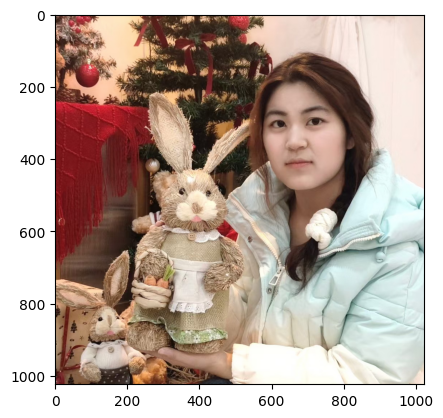

token embedding shape torch.Size([1, 77, 768])
token embedding shape torch.Size([1, 77, 768])
input image is none,use random noise instead
timesteps typetorch.int64


  0%|          | 0/50 [00:00<?, ?it/s]

timesteps  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:07<00:00,  6.51it/s]


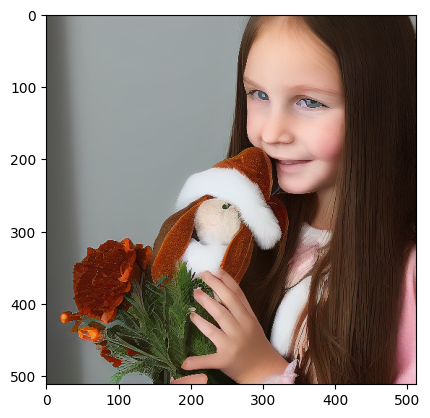

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
import torch
from transformers import CLIPTokenizer
import numpy as np
from StableDiffusion.Utils import Utils
import matplotlib.pyplot as plt
import StableDiffusion.DdpmSamplerTorch
import StableDiffusion.TimeEmbedding
import StableDiffusion.Utils
import StableDiffusion.UnetGlobalCrossAttentionBlock
import StableDiffusion.UnetDenoise
import importlib
importlib.reload(StableDiffusion.DdpmSamplerTorch)
importlib.reload(StableDiffusion.TimeEmbedding)
importlib.reload(StableDiffusion.Utils)
importlib.reload(StableDiffusion.UnetGlobalCrossAttentionBlock)
importlib.reload(StableDiffusion.UnetDenoise)
from StableDiffusion.DdpmSamplerTorch import DdpmSamplerTorch
from StableDiffusion.TimeEmbedding import TimeEmbedding
from StableDiffusion.Utils import Utils
from StableDiffusion.UnetGlobalCrossAttentionBlock import UnetGlobalCrossAttentionBlock
from StableDiffusion.UnetDenoise import UnetDenoise
#img1 = cv2.imread('./images/pusiyue_front_1024_1024.jpg')
#img1 = cv2.imread('./images/apple.jpg')
filePath = './images/apple.jpg'
filePath ='./images/pusiyue_front_1024_1024.jpg'
imgBatch = Utils.loadImageBatch(filePath)
Width = 512
Height = 512
LatentWidth = Width//8
LatentHeight = Height//8
LatentShape = (1,4,LatentHeight,LatentWidth)
#LatentShape = (4,4,LatentHeight,LatentWidth)
imgBatch = imgBatch.to(device)
inputImage = imgBatch
inputImage = None
isDoingCfg = False
isDoingCfg = True
numInferenceSteps = 50
#cfgScale = 7.5
cfgScale = 7.5
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# This forces the GPU to use slower, deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

randomGenerator = torch.Generator(device=device)
randomGenerator.manual_seed(seed)
sampler = DdpmSamplerTorch(randomGenerator=randomGenerator,
                           numTrainingSteps=1000,
                           numInferenceSteps=numInferenceSteps)
promptPositive = [
        '1girl, solo, long_hair, looking_at_viewer, brown_hair, \
            hair_ornament, holding, jacket, black_eyes, lips,\
        stuffed_toy, scrunchie, stuffed_animal, christmas, \
            realistic, stuffed_bunny, carrot, christmas_tree, christmas_ornaments'  #wd14 tag
            
        #'a girl walking on a Chrismas street in a snowing day', \
         #  'a woman holding two stuffed rabbits in front of a christmas tree',      
        #'a cat sitting by window while snow falls from the sky',
        #'10 cat'
        #'1boy'
        #'a girl playing with a cat in a snowing day'
        #'a cat sitting by window while snow falls from the sky'
        'a girl holding a bundle of flowers in a vase,highresolutin,masterpiece,best quality,8k'
        ]
#promptNegative = ['blur, ugly, bad, poor']    
promptNegative =['lowres, {bad}, error, fewer, extra,\
                 missing, worst quality, jpeg artifacts, \
                 bad quality, watermark, unfinished, \
                displeasing, chromatic aberration, signature, \
                    extra digits, artistic error, username, \
                        scan, [abstract]']
promptPositiveTokens,attentionMaskPositive = Utils.getPromptTokens(promptPositive,device=device)
promptNegativeTokens,attentionMaskNegative = Utils.getPromptTokens(promptNegative,device=device)
clipInputsPositive =promptPositiveTokens
clipInputsNegative = promptNegativeTokens
vaeEncoder.eval()
vaeDecoder.eval()
diffusionProcess.eval()
clipEncoder.eval()
imgStepList = []
with torch.no_grad():
    clipOutputsPositive = clipEncoder(clipInputsPositive,attentionMask = attentionMaskPositive)
    clipOutputsNegative = clipEncoder(clipInputsNegative,attentionMask = attentionMaskNegative)   
    #clipOutputsPositive = clipEncoder(clipInputsPositive,attentionMask = None)
    #clipOutputsNegative = clipEncoder(clipInputsNegative,attentionMask = None) 
    #print(clipOutputs)
    
    if isDoingCfg == True:
        clipOutputs = torch.cat([clipOutputsPositive,clipOutputsNegative])
    else:
        clipOutputs = clipOutputsPositive
        
    
    if inputImage is not None:
        
        print(f'use input image to guide image generation')
        inputNoise =torch.randn(LatentShape,generator=randomGenerator,device=device)      
        #inputNoise = None
        latentNoised = vaeEncoder(inputImage,inputNoise)
        sampler.setAddNoiseStrength(0.3)
        time = sampler.getInferenceTimeSteps()[0].to(device)
        latentNoised = sampler.addNoise(latentNoised,time)
        imageDecodedDirect = vaeDecoder(latentNoised)       
        Utils.showBatchImage(imageDecodedDirect)
        
    else: 
        print(f'input image is none,use random noise instead')
        latentNoised = torch.randn(LatentShape,generator=randomGenerator,device=device)
    
    timesteps = sampler.getInferenceTimeSteps() 
    print(f'timesteps type{timesteps.dtype}')       
    
    timesteps = tqdm(timesteps)
    print(f'timesteps{timesteps}')
    for i,time in enumerate(timesteps):
        #print(f'i step: {i} time step: {time} {time.device}')              
        timeEmbedding320 = Utils.getTimeEmbedding(time)    
        timeEmbedding320= sampler.numpy2Tensor(timeEmbedding320,device=device)
        modelNoisedLatentInput = latentNoised
        contextInput = clipOutputs
        if isDoingCfg == True:
            #print(f'is doing cfg scale {cfgScale}')
            modelNoisedLatentInput = modelNoisedLatentInput.repeat(2,1,1,1)
            #print(f'doing cfg scale latent inputs shape  {modelNoisedLatentInput.shape}') 
        
        #print(f'latentinput device: {modelNoisedLatentInput.device}  contextinput device: {contextInput.device} timeembed device: {timeEmbedding320.device}')
        #print(f'latent input: {modelNoisedLatentInput} contextinput: {contextInput} timeinput: {timeEmbedding320}')
        #print(f'latent input: {modelNoisedLatentInput.shape} contextinput: {contextInput.shape} timeinput: {timeEmbedding320.shape}')
        modelEstimatedNoiseInLatent  = diffusionProcess(modelNoisedLatentInput,contextInput,timeEmbedding320)
        
        if isDoingCfg == True:
            #print(f'is doing cfg scale {cfgScale}')
            positiveEstimate,negativeEstimate = modelEstimatedNoiseInLatent.chunk(2,dim=0)
            #print(modelEstimatedNoiseInLatent.shape,positiveEstimate.shape,negativeEstimate.shape)
            modelEstimatedNoiseInLatent = cfgScale * positiveEstimate  + (1-cfgScale) * negativeEstimate
            #print(f'after cfg scale {positiveEstimate.shape} {negativeEstimate.shape} {modelEstimatedNoiseInLatent.shape}')
            modelNoisedLatentInput = latentNoised
            #added 20260223 to make sure the input back to batch size 1
        

        #print(f'latent  noise  time input beforme remove noise  {modelNoisedLatentInputNumpy.shape} context input {contextInputNumpy.shape} time embedding {timeEmbedding320Numpy.shape}')
        cleanerLatent = sampler.removeNoiseFromLatent(modelNoisedLatentInput,modelEstimatedNoiseInLatent,time)        
        latentNoised  = cleanerLatent
        #print(f'latent input at the end while step {i} {latentNoised.shape}')
        
        #print(f'latent noised {latentNoised.shape} {latentNoised}')
        imageDecoded = vaeDecoder(latentNoised)
        imgStepList.append(imageDecoded)
        #if i % 10 == 0:
            #imageDecoded = vaeDecoder(latentNoised)         
            #Utils.showBatchImage(imageDecoded)
        

Utils.showBatchImage(imgStepList[-1]) 
#imageDecoded = vaeDecoder(latentNoised)         
#Utils.showBatchImage(imageDecoded)    


    
    

50
50


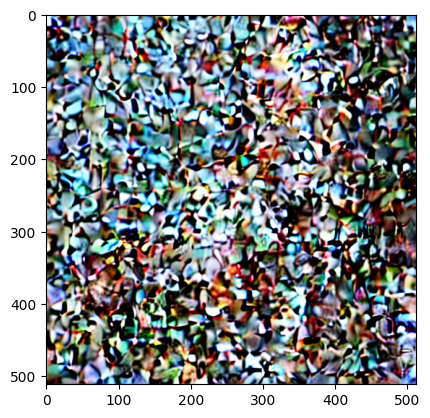

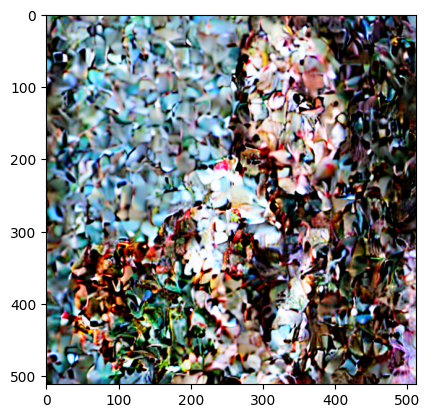

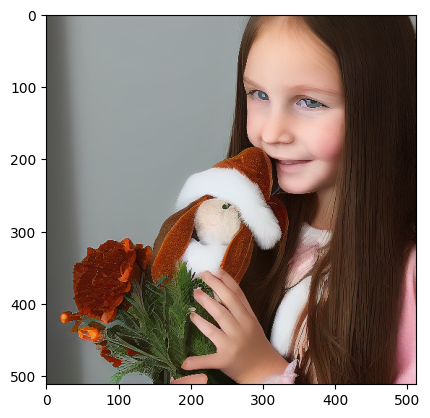

In [5]:
print(len(imgStepList))
timeSteps = sampler.getInferenceTimeSteps()
ListLength = timeSteps.shape[0]
print(ListLength)
Utils.showBatchImage(imgStepList[ListLength//3])
Utils.showBatchImage(imgStepList[ListLength//3 *2-1])
Utils.showBatchImage(imgStepList[ListLength-1])

Detected legacy `from_single_file` loading behavior. Attempting to create the pipeline based on inferred components.
This may lead to errors if the model components are not correctly inferred. 
To avoid this warning, please explicitly pass the `config` argument to `from_single_file` with a path to a local diffusers model repo 
e.g. `from_single_file(<my model checkpoint path>, config=<path to local diffusers model repo>) 
or run `from_single_file` with `local_files_only=False` first to update the local cache directory with the necessary config files.

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging

<class 'PIL.Image.Image'>


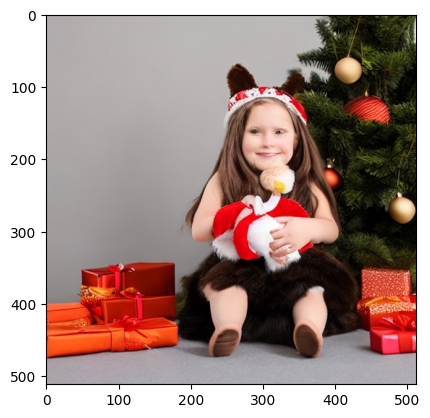

In [4]:
import torch
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer, CLIPTextModel
import  matplotlib.pyplot as plt
import numpy as np

# Paths
clip_path = "/home/aistudio/models/openai-clip-vit-large-patch14"
model_path = "/home/aistudio/models/sd15safetensor/v1-5-pruned-emaonly.safetensors"
config_file = "/home/aistudio/models/sd15safetensor/v1-inference.yaml"

# 1️ Load tokenizer + text encoder
tokenizer = CLIPTokenizer.from_pretrained(
    clip_path,
    local_files_only=True
)

text_encoder = CLIPTextModel.from_pretrained(
    clip_path,
    torch_dtype=torch.float32,
    local_files_only=True
)

# 2️ Load pipeline and inject components
pipe = StableDiffusionPipeline.from_single_file(
    model_path,
    original_config_file=config_file,
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    torch_dtype=torch.float32,
    use_safetensors=True,
    local_files_only=True
)

pipe.to("cuda")

# Optional but recommended
pipe.enable_attention_slicing()
# 3️ Generate
'''
promptPositive = '1girl, solo, long_hair, looking_at_viewer, brown_hair, \
            hair_ornament, holding, jacket, black_eyes, lips,\
        stuffed_toy, scrunchie, stuffed_animal, christmas, \
            realistic, stuffed_bunny, carrot, christmas_tree, christmas_ornaments'  #wd14 tag
promptNegative ='lowres, {bad}, error, fewer, extra,\
                 missing, worst quality, jpeg artifacts, \
                 bad quality, watermark, unfinished, \
                displeasing, chromatic aberration, signature, \
                    extra digits, artistic error, username, \
                        scan, [abstract]'
'''
generator = torch.Generator(device='cuda').manual_seed(42)
image = pipe(
    prompt = promptPositive,
    negative_prompt=promptNegative,
    num_inference_steps=50,
    generator=generator,
    guidance_scale=7.5
).images[0]

#image.save("output.png")
print(type(image))
imgNumpy = np.array(image)
plt.imshow(imgNumpy)
plt.show()


In [8]:
a = pipe.feature_extractor
if a is not None:
    print(a)
else:
    print(f'a is none')

a is none


In [47]:
pipe.scheduler
pipe.unet
pipe.vae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

in ddpm start step is 9
timesteps: tensor([900, 890, 880, 870, 860, 850, 840, 830, 820, 810, 800, 790, 780, 770,
        760, 750, 740, 730, 720, 710, 700, 690, 680, 670, 660, 650, 640, 630,
        620, 610, 600, 590, 580, 570, 560, 550, 540, 530, 520, 510, 500, 490,
        480, 470, 460, 450, 440, 430, 420, 410, 400, 390, 380, 370, 360, 350,
        340, 330, 320, 310, 300, 290, 280, 270, 260, 250, 240, 230, 220, 210,
        200, 190, 180, 170, 160, 150, 140, 130, 120, 110, 100,  90,  80,  70,
         60,  50,  40,  30,  20,  10,   0])
noise time step start : 900
vae encoder input noise is none  use zeros


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57412386..1.3030851].


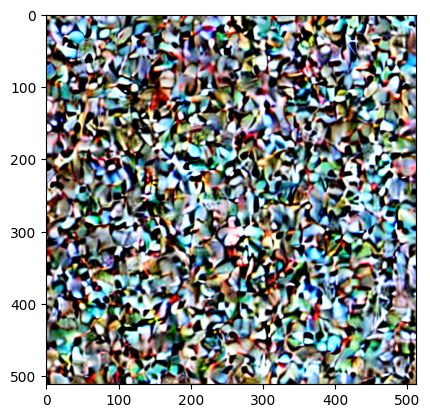

In [95]:
sampler = DdpmSamplerTorch(randomGenerator=randomGenerator,
                           numTrainingSteps=1000,
                           numInferenceSteps=numInferenceSteps)
sampler.setAddNoiseStrength(0.9)
timeSteps = sampler.getInferenceTimeSteps()
print(f'timesteps: {timeSteps}')
time = sampler.getInferenceTimeSteps()[0].to(device)
print(f'noise time step start : {time }')
latentNoised = vaeEncoder(inputImage.to(device))
latentNoised = sampler.addNoise(latentNoised,time)
imageDecodedDirect = vaeDecoder(latentNoised)       
Utils.showBatchImage(imageDecodedDirect)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.74650323..2.2043948].


use input image to guide image generation
vae encoder input noise.shape torch.Size([1, 4, 64, 64])


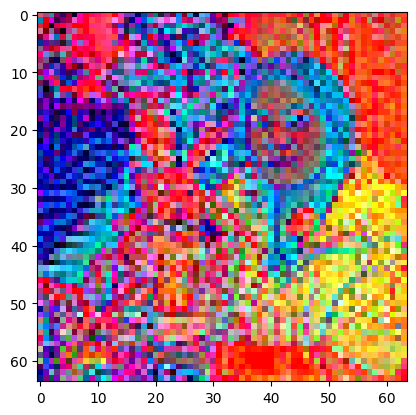

In [96]:
print(f'use input image to guide image generation')
inputNoise =torch.randn(LatentShape,generator=randomGenerator,device=device)      

latentNoised = vaeEncoder(inputImage,inputNoise)
Utils.showBatchImage(latentNoised[0:,1:,:,:])

In [26]:
print(LatentShape)

(1, 4, 64, 64)


In [25]:
print(f'sampler.alphas {sampler.alphas}')
print(f'sampler.betas {sampler.betas}')
print(f'sampler.alphasBar {sampler.alphasBar}')
print(f'sampler.betasBar {sampler.betasBar}')


sampler.alphas tensor([0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9989, 0.9989, 0.9989, 0.9989,
        0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989,
        0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9988, 0.9988, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987, 0.9987,
        0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987,
        0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9986, 0.9986, 0.9986, 0.9986,
        0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986,
        0.9986, 0.9986, 0

In [22]:
sampler.getInferenceTimeSteps()


tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61985385..1.3449364].


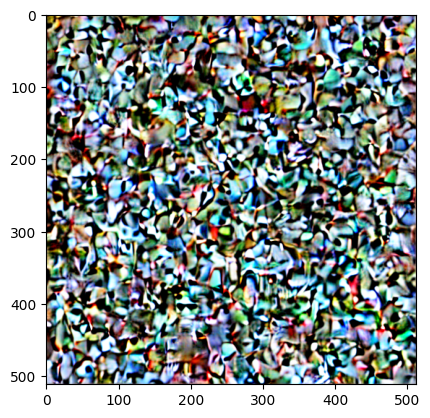

In [62]:
imageDecoded = vaeDecoder(latentNoised)         
Utils.showBatchImage(imageDecoded)   

In [8]:
timeEmbed = Utils.getTimeEmbedding(0)
print(timeEmbed)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
sampler.getVariance(940)
sampler.getVariance(10)

tensor(1.0000e-20)

In [13]:
sampler.deltaSteps
sampler.getPreviousTimeStep(960)
sampler.betas
sampler.alphasBar

tensor([0.9991, 0.9983, 0.9974, 0.9966, 0.9957, 0.9948, 0.9940, 0.9931, 0.9922,
        0.9913, 0.9904, 0.9895, 0.9886, 0.9877, 0.9868, 0.9859, 0.9850, 0.9841,
        0.9832, 0.9822, 0.9813, 0.9804, 0.9794, 0.9785, 0.9776, 0.9766, 0.9757,
        0.9747, 0.9737, 0.9728, 0.9718, 0.9708, 0.9698, 0.9689, 0.9679, 0.9669,
        0.9659, 0.9649, 0.9639, 0.9629, 0.9619, 0.9609, 0.9599, 0.9588, 0.9578,
        0.9568, 0.9557, 0.9547, 0.9537, 0.9526, 0.9516, 0.9505, 0.9495, 0.9484,
        0.9473, 0.9463, 0.9452, 0.9441, 0.9430, 0.9420, 0.9409, 0.9398, 0.9387,
        0.9376, 0.9365, 0.9354, 0.9343, 0.9332, 0.9320, 0.9309, 0.9298, 0.9287,
        0.9275, 0.9264, 0.9252, 0.9241, 0.9229, 0.9218, 0.9206, 0.9195, 0.9183,
        0.9171, 0.9160, 0.9148, 0.9136, 0.9124, 0.9112, 0.9100, 0.9089, 0.9077,
        0.9065, 0.9052, 0.9040, 0.9028, 0.9016, 0.9004, 0.8992, 0.8979, 0.8967,
        0.8955, 0.8942, 0.8930, 0.8917, 0.8905, 0.8892, 0.8880, 0.8867, 0.8854,
        0.8842, 0.8829, 0.8816, 0.8804, 

vae encoder input noise is none  use zeros
latent shape: torch.Size([1, 4, 64, 64])
recon shape: torch.Size([1, 3, 512, 512])
reconAdjust: tensor([[[[-0.0792,  0.1659,  0.3394,  ...,  0.8085,  0.7934,  0.8135],
          [ 0.0258,  0.1638,  0.3630,  ...,  0.8081,  0.8104,  0.8352],
          [-0.0889,  0.0755,  0.2130,  ...,  0.8098,  0.8139,  0.8372],
          ...,
          [ 0.1248,  0.2823,  0.1762,  ...,  0.9742,  0.9917,  0.9768],
          [ 0.1354,  0.2326,  0.0786,  ...,  0.9814,  0.9801,  0.9716],
          [ 0.0357,  0.1018,  0.1114,  ...,  0.9653,  0.9918,  0.9462]],

         [[-0.2529, -0.0789,  0.1032,  ...,  0.6596,  0.6605,  0.7024],
          [-0.1876, -0.0962,  0.1332,  ...,  0.6652,  0.6562,  0.6870],
          [-0.3292, -0.1629, -0.0010,  ...,  0.6635,  0.6712,  0.6921],
          ...,
          [-0.4452, -0.4153, -0.5373,  ...,  0.8947,  0.8916,  0.9069],
          [-0.4499, -0.5755, -0.7329,  ...,  0.8877,  0.8858,  0.8936],
          [-0.4440, -0.5723, -0.6936,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.419006..9.907535].


latentAdjust: tensor([[[[-1.2730e+00, -3.3108e-01,  3.7090e-01,  ...,  1.7374e+00,
            1.4623e+00,  1.1753e+00],
          [ 3.2733e-02, -6.0405e-01,  9.5317e-01,  ...,  1.6030e+00,
            1.2433e+00,  1.2614e+00],
          [-1.4118e-01, -1.1759e+00, -6.4781e-02,  ...,  1.6233e+00,
            1.3293e+00,  1.6090e+00],
          ...,
          [-5.2781e-01,  8.8786e-01, -9.8389e-02,  ...,  1.2549e+00,
            5.2805e-01,  1.3548e+00],
          [-6.1401e-01,  8.2550e-02,  7.1123e-01,  ...,  6.2038e-01,
            1.4806e+00,  1.6679e+00],
          [ 7.2303e-01, -2.2038e-01, -9.9471e-01,  ...,  8.0455e-01,
            1.4245e+00,  2.0280e+00]],

         [[ 8.0804e-01,  2.9237e-01, -6.3057e-01,  ...,  7.5774e-01,
            8.5624e-01,  1.1597e+00],
          [-1.0888e+00,  8.2759e-01,  6.2752e-01,  ...,  6.0267e-01,
            4.8105e-01,  1.3594e+00],
          [ 7.2224e-01,  7.2632e-01, -9.5766e-01,  ...,  6.4733e-01,
            7.7248e-01,  1.3604e+00],
      

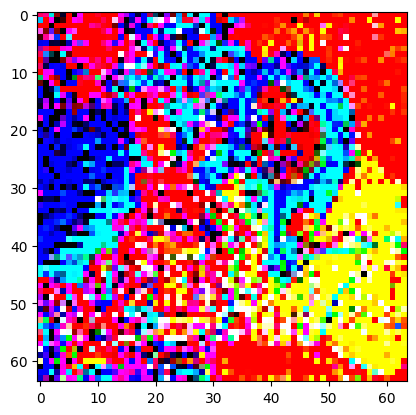

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.083337426..1.0286468].


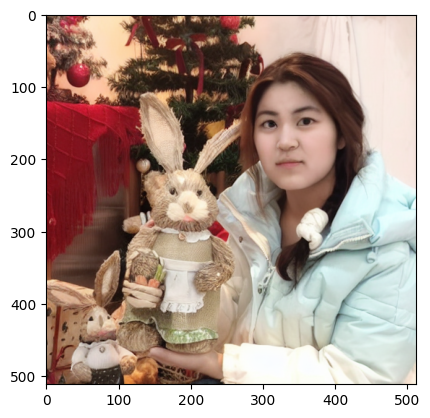

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.034323275..1.0286078].


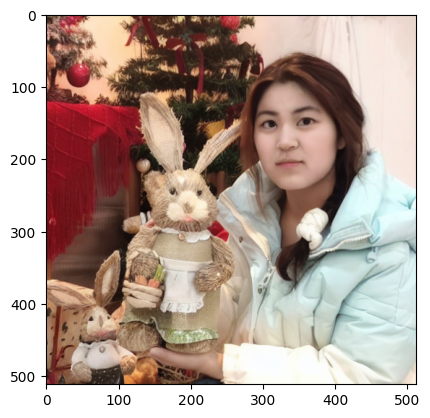

In [20]:
from diffusers import AutoencoderKL
import torch
import StableDiffusion.Utils
import StableDiffusion.VaeDecoder
import StableDiffusion.VaeEncoder
import importlib 
importlib.reload(StableDiffusion.Utils)
importlib.reload(StableDiffusion.VaeDecoder)
importlib.reload(StableDiffusion.VaeEncoder)

from StableDiffusion.Utils import Utils
from StableDiffusion.VaeEncoder import VaeEncoder
from StableDiffusion.VaeDecoder import VaeDecoder

seed = 420
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# Path to folder
vaePath = "../models/sd15vae/"

# Load model
vaeModel = AutoencoderKL.from_pretrained(
    vaePath,
    use_safetensors=True,      # tells Diffusers to load safetensors
    torch_dtype=torch.float32  # optional: faster and matches SD usually
)


# Example random image
#x = torch.randn(1, 3, 512, 512).cuda()  # SD1.5 works with 512x512 images
x = imgBatch.to("cuda")
# Move to GPU
vaeModel = vaeModel.to("cuda")
vaeModel.eval()  # important for inference
vaeEncoder.eval()
vaeDecoder.eval()
with torch.no_grad():
    seed = 420
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    encoderImg = vaeEncoder(x,None)
    decoderImgTensor = vaeDecoder(encoderImg)
    seed = 420
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    latent = vaeModel.encode(x).latent_dist.sample()  # encode to latent   
    latentAdjust = latent * 0.18215
    recon = vaeModel.decode(latentAdjust/0.18215).sample          # decode back to image
    reconAdjust = recon/1.0
print("latent shape:", latent.shape)  # [1, 4, 64, 64]
print("recon shape:", recon.shape)    # [1, 3, 512, 512]


print(f'reconAdjust: {reconAdjust}')
print(f'decoderImgTensor: {decoderImgTensor}')
#print(torch.max(recon,dim=1))
#print(torch.max(decoderImgTensor,dim=1))




#print(torch.max(latentAdjust,dim=1))
#print(torch.max(encoderImg,dim=1))
print(f'latentAdjust: {latentAdjust}')
print(f'encoderImg: {encoderImg}')

if torch.allclose(recon, decoderImgTensor,atol=0.15):
    print('recon decoderImg are close enough')
else:
    print('recon decoderImg are not close enough')
#latentAdjust = latent*0.18215

if torch.allclose(latentAdjust, encoderImg, atol=0.2):
    print('latentAdjust and encoderImg are close enough')
else:
    print('lantentAdjust and encoderImg are not close enough')








latentImg = latent[0:,1:,:,:]
print(latentImg.shape)
Utils.showBatchImage(latentImg)
Utils.showBatchImage(reconAdjust)
Utils.showBatchImage(decoderImgTensor)


In [8]:
import torch
from transformers import CLIPTokenizer, CLIPTextModel

modelPath = "../models/openai-clip-vit-large-patch14"

# 1. Load Tokenizer and Model
tokenizer = CLIPTokenizer.from_pretrained(modelPath)
openaiClipModel = CLIPTextModel.from_pretrained(modelPath).to(device)
openaiClipModel.eval()
prompt = promptNegative
inputs = tokenizer(
    prompt, 
    padding="max_length", 
    max_length=77, 
    truncation=True, 
    return_tensors="pt"
).to(device)
# 3. Forward Pass
with torch.no_grad():
    outputs = openaiClipModel(**inputs)

print(promptNegative)
print(attentionMaskNegative)
# last_hidden_state shape: [batch_size, sequence_length, hidden_size]
# For SD 1.5, this is [1, 77, 768]
text_embeddings = outputs.last_hidden_state

print(f'clipOutputsPositive {clipOutputsNegative}')
print(f'text_embeddings {text_embeddings}')
      

['lowres, {bad}, error, fewer, extra,                 missing, worst quality, jpeg artifacts,                  bad quality, watermark, unfinished,                 displeasing, chromatic aberration, signature,                     extra digits, artistic error, username,                         scan, [abstract]']
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]], device='cuda:0')
clipOutputsPositive tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.5221, -0.3726,  1.6821,  ..., -0.2066,  0.3460, -1.2067],
         [ 0.7152, -0.3183,  0.7775,  ...,  0.2600, -0.3660,  0.1060],
         ...,
         [ 0.0886, -0.5617,  1.0229,  ..., -1.5668, -0.0860, -0.6523],
         [ 0.0804, -0.5770,  1.0937,  ..., -1.5565, -0.0875, -0.5846],
         [ 0.

In [7]:
import torch
from transformers import CLIPTokenizer, CLIPTextModel

modelPath = "../models/openai-clip-vit-large-patch14"

# 1. Load Tokenizer and Model
tokenizer = CLIPTokenizer.from_pretrained(modelPath)
openaiClipModel = CLIPTextModel.from_pretrained(modelPath).to(device)
openaiClipModel.eval()
prompt = promptPositive
inputs = tokenizer(
    prompt, 
    padding="max_length", 
    max_length=77, 
    truncation=True, 
    return_tensors="pt"
).to(device)
# 3. Forward Pass
with torch.no_grad():
    outputs = openaiClipModel(**inputs)

print(promptPositive)
# last_hidden_state shape: [batch_size, sequence_length, hidden_size]
# For SD 1.5, this is [1, 77, 768]
text_embeddings = outputs.last_hidden_state

print(f'clipOutputsPositive {clipOutputsPositive}')
print(f'text_embeddings {text_embeddings}')
      

['a woman holding two stuffed rabbits in front of a christmas tree']
clipOutputsPositive tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 1.2391,  0.5542,  0.7436,  ..., -0.7556, -0.4562, -0.7371],
         ...,
         [-0.2949, -0.5649,  0.2568,  ..., -0.6738,  0.1704, -0.3716],
         [-0.2585, -0.3915,  0.2429,  ..., -0.5988,  0.0596, -0.2496],
         [-0.1594, -1.4494, -0.5195,  ...,  0.6636, -0.1474, -1.2938]]],
       device='cuda:0')
text_embeddings tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 1.2391,  0.5542,  0.7436,  ..., -0.7556, -0.4562, -0.7371],
         ...,
         [-0.2949, -0.5649,  0.2568,  ..., -0.6738,  0.1704, -0.3716],
         [-0.2585, -0.3915,  0.2429,  ..., -0.5988,  0.0596, -0.2496],
         [-0.1594, -1.4494, -0.5195,  ...,  0.6636, -0.1474,

In [6]:
import torch

ckpt = torch.load(
    "/home/aistudio/models/sd15models/v1-5-pruned-emaonly.ckpt",
    map_location="cpu",
    weights_only=False  # IMPORTANT
)

print(type(ckpt))
print(ckpt.keys())

<class 'dict'>
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'lr_schedulers'])


In [3]:
from diffusers import PNDMScheduler

# Your provided dictionary
scheduler_config = {
  "_class_name": "PNDMScheduler",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "set_alpha_to_one": False,
  "skip_prk_steps": True,
  "steps_offset": 1,
  "trained_betas": None,
  "clip_sample": False
}

# This creates the scheduler object purely from your JSON data
scheduler = PNDMScheduler.from_config(scheduler_config)


